In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-10-05 22:46:48.695933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 22:46:49.459737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
@tf.function
def bc_func(model, X, u, u_x):
    u_pred = model(X, training=True)
    u_x_pred = tf.gradients(u_pred, X)[0]
    bc_loss_f = u_pred - u
    bc_loss_df = u_x_pred - u_x
    return bc_loss_f, bc_loss_df

@tf.function
def ode_func(model, X):
    k = 1.0
    u = model(X, training=True)
    u_x = tf.gradients(u, X)[0]
    u_xx = tf.gradients(u_x, X)[0]
    return u_xx + k*u

@tf.function
def loss_func(model, X_b, u_b, u_x_b, X_f):
        
    bc_f, bc_df = bc_func(model, X_b, u_b, u_x_b)
    
    domain = ode_func(model, X_f)
                
    return tf.reduce_mean(tf.square(bc_f)) + \
           tf.reduce_mean(tf.square(bc_df)) + \
           tf.reduce_mean(tf.square(domain))

@tf.function
def loss_and_gradients(model, X_b, u_b, u_x_b, X_f):

    with tf.GradientTape(persistent=True) as tape:
        total_model_loss=loss_func(model, X_b, u_b, u_x_b, X_f)
    model_gradients = tape.gradient(total_model_loss, model.trainable_weights)
    
    return total_model_loss, model_gradients

In [3]:
def train(model, train_data):
    
    optimizer = tf.keras.optimizers.Adam()
    nIter = 1000
        
    X_b = train_data['X_b']
    u_b = train_data['u_b']
    u_x_b = train_data['u_x_b']
    X_f = train_data['X_f']

    losses = []
    
    for it in range(nIter):
        
        model_loss, model_gradients = loss_and_gradients(model, X_b, u_b, u_x_b, X_f)
        optimizer.apply_gradients(zip(model_gradients, model.trainable_weights))
        
        losses.append(model_loss)
        
        if (it % 100 == 0):
            print(f'{model_loss} {it}')
            
    return np.array(losses)

In [4]:
inputs  = tf.keras.Input(shape=(1,))
layer1  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(inputs)
layer2  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer1)
layer3  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer2)
layer4  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer3)
outputs = tf.keras.layers.Dense(units = 1, activation=None)(layer4)
model = tf.keras.Model(inputs, outputs)

2023-10-05 22:46:56.509576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 22:46:56.531611: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50

In [6]:
model.save_weights('model.h5')

In [7]:
N = 20

In [8]:
X = np.linspace(0.0, 2.0*np.pi, N)[:,None] #Slicing to make a *column* vector

In [9]:
X_b = X[0:1,:]

In [10]:
X_b

array([[0.]])

In [11]:
u_b = X_b.copy()

In [12]:
u_b[:,:] = 0.0

In [13]:
u_b, u_b.shape

(array([[0.]]), (1, 1))

In [14]:
u_x_b = u_b.copy()
u_x_b[:,:] = 1.0

In [15]:
u_x_b, u_x_b.shape

(array([[1.]]), (1, 1))

In [16]:
idx = np.random.choice(X.shape[0], N, replace=False)
X_f = X[idx,:]

In [17]:
X_f.shape

(20, 1)

In [18]:
training_data = {'X_b': X_b.astype('float32'),
                 'u_b': u_b.astype('float32'),
                 'u_x_b': u_x_b.astype('float32'),
                 'X_f': X.astype('float32')}

In [19]:
model.load_weights('model.h5') 
# Puedo comenzar de cero desde esta celda, ya que el modelo guardado tiene pesos aleatorios, sin entrenamiento

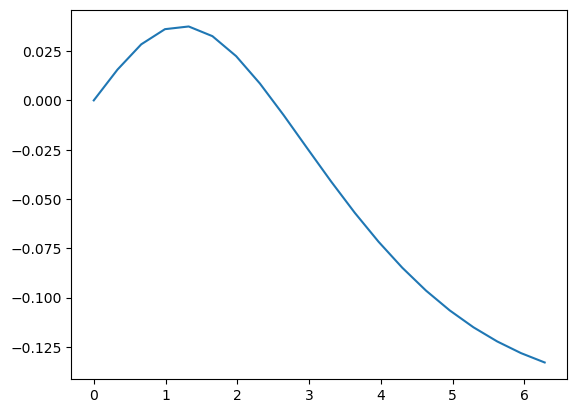

In [20]:
plt.plot(X, model(X).numpy())

In [21]:
losses = train(model, training_data)

0.9090337753295898 0
0.06929253041744232 100
0.05433440953493118 200
0.03309465944766998 300
0.017842775210738182 400
0.00492766872048378 500
0.0019226688891649246 600
0.0006546351942233741 700
0.00027285440592095256 800
0.001114902668632567 900


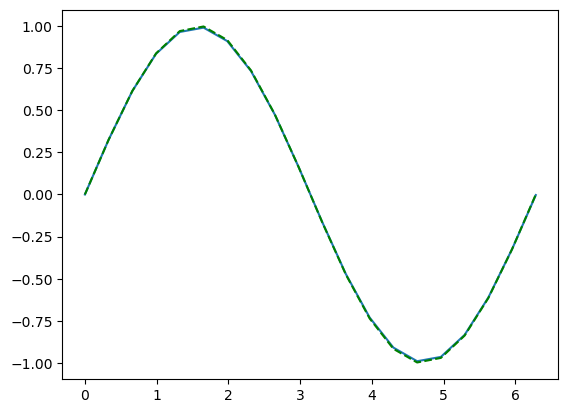

In [22]:
plt.plot(X, model(X).numpy())
plt.plot(X, np.sin(X), 'g--')

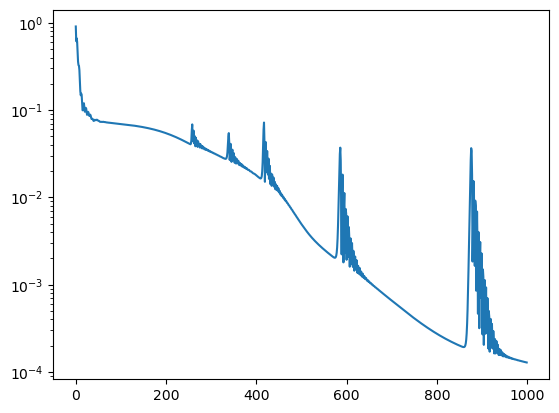

In [23]:
plt.plot(losses)
plt.yscale('log')